# SMFES Homework 2

Georgy Andryushchenko

## Dependencies Installation

In [ ]:
!pip install pysd

In [2]:
import matplotlib.pyplot as plt

In [3]:
#!pip install pysd
%pylab inline
import pysd
#model = pysd.read_vensim('bass.mdl')

Populating the interactive namespace from numpy and matplotlib


## 1. Implement a modified Bass model

Check `bass.py` file for the implementation

In [4]:
model = pysd.load('bass.py')

## 2. Evaluate the convergence of the model, i.e. the stability of the proportion of the distribution of customers.

1. Convergence Definition  
Let us define convergence of a sequence as follows: A sequence $x$ converges iff for any $\epsilon$ there exist $N$ such that $|x_n - x_{n-1}| \leq \epsilon$ for each $n \geq N$.
2. Convergence Time  
Let convergence time $T$ be equal to the final time of the simulation.
3. $M_1$ and $M_2$  
Let $M_1$ be the value of the clients concentration at time $T$.

m1 converges: True
m2 converges: True


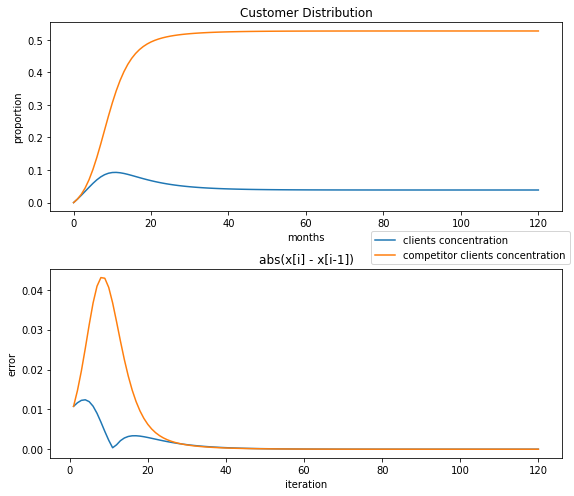

In [ ]:
from math import floor, ceil
import numpy as np

# searches N for the given epsilon
# such that abs(x[n] - x[n-1])
# for each N <= n <= T
def find_n(errors, eps):
    for n in range(len(errors)):
        is_found = True
        for i in range(n, len(errors)):
            if errors[i] > eps:
                is_found = False
                break
        if is_found:
            return True

    return False

# checks convergence of the sequence by
# finding N for each epsilon 
def check_convergence(errors):
    eps_range = range(ceil(min(errors)), ceil(max(errors)))
    for eps in eps_range:
        if not find_n(errors, eps):
            return False

    return True

FINAL_TIME = 12 * 10 # 10 years

# run a simulation with 
values = model.run(
    initial_condition='original',
    params={
        'p11': 0.1,
        'p13': 0.2,
        'p21': 0.3,
        'p23': 0.4
    },
    final_time=FINAL_TIME,
    return_columns=['clients concentration', 'competitor clients concentration']
)

# calculate x[n] - x[n-1]
m1_error = list()
m2_error = list()
for i in range(1, FINAL_TIME+1):
    m1_error.append(abs(values.iloc[i][0] - values.iloc[i-1][0]))
    m2_error.append(abs(values.iloc[i][1] - values.iloc[i-1][1]))

# check whether m1 and m2 sequences converge
print('m1 converges:', check_convergence(m1_error))
print('m2 converges:', check_convergence(m2_error))

# draw the plots
fig, axs = plt.subplots(2, figsize=(8,7))

axs[0].set_title("Customer Distribution")
axs[0].set_xlabel("months")
axs[0].set_ylabel("proportion")
axs[0].plot(values)

axs[1].set_title("abs(x[i] - x[i-1])")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("error")
axs[1].plot(range(1, FINAL_TIME+1), m1_error)
axs[1].plot(range(1, FINAL_TIME+1), m2_error)

fig.legend(labels=values.columns, loc = 'center right')

fig.tight_layout()

As you can see, the values of $|x_n - x_{n-1}|$ monotonically decrease to 0 during the time of simulation. For each $\epsilon$ we can find $N \leq T$ such that $|x_n - x_{n-1}|$ is not greater than epsilon for each $n > N$. It means that the sequences converge. 

## 3. ML Model

### 0. Collect a dataset

In order to collect the dataset we vary parameters $(p_{11}, p_{13}, p_{21}, p_{23})$. The values for the parameters are taken from the set of 10 evenly spaced values that belong to range from 0 to 1(`np.linspace(0,1,10)`). During variation we check the values of p whether they satisfy the necessary conditions. If they satisfy then we run the simulation with the current parameters and get a pair of values $(M_1, M_2)$ at $T$.

In [69]:
# setting simulation time to 2 years 
FINAL_TIME = 2 * 12

In [84]:
# import progressbar to check the progress
from tqdm import tqdm

# the values of parameters to variate
params_range = np.linspace(0,1,11)

p11_list = list()
p13_list = list()
p21_list = list()
p23_list = list()
m1_list = list()
m2_list = list()

# bruteforce the parameters of p
for p11 in tqdm(params_range):
    for p13 in params_range:
        for p21 in params_range:
            for p23 in params_range:
                if p11+p13 <= 1 and p21+p23 <= 1:
                    p11_list.append(p11)
                    p13_list.append(p13)
                    p21_list.append(p21)
                    p23_list.append(p23)

                    # run the simulation with current params
                    values = model.run(
                        initial_condition='original',
                        params={
                            'p11': p11,
                            'p13': p13,
                            'p21': p21,
                            'p23': p23
                        },
                        final_time=FINAL_TIME,
                        return_columns=[
                            'clients concentration',
                            'competitor clients concentration'
                        ]
                    )

                    # calculate values of abs(x[n] - x[n-1]) for both M1 and M2
                    m1_error = list()
                    m2_error = list()
                    for i in range(1, FINAL_TIME+1):
                        m1_error.append(abs(values.iloc[i][0] - values.iloc[i-1][0]))
                        m2_error.append(abs(values.iloc[i][1] - values.iloc[i-1][1]))

                    # get values of M1 and M2
                    m1_list.append(values.iloc[-1][0])
                    m2_list.append(values.iloc[-1][1])

100%|██████████| 11/11 [02:02<00:00, 11.11s/it]


In [85]:
import pandas as pd

# compose a dataframe
df = pd.DataFrame(
    data={
        'p11': p11_list,
        'p13': p13_list,
        'p21': p21_list,
        'p23': p23_list,
        'm1': m1_list,
        'm2': m2_list
    }
)

In [86]:
df

,p11,p13,p21,p23,m1,m2
0,0.0,0.0,0.0,0.0,0.172775,0.172775
1,0.0,0.0,0.0,0.1,0.163401,0.163401
2,0.0,0.0,0.0,0.2,0.155260,0.155260
3,0.0,0.0,0.0,0.3,0.148119,0.148119
4,0.0,0.0,0.0,0.4,0.141800,0.141800
...,...,...,...,...,...,...
4351,1.0,0.0,0.8,0.1,0.758087,0.169960
4352,1.0,0.0,0.8,0.2,0.726604,0.171544
4353,1.0,0.0,0.9,0.0,0.685879,0.281335
4354,1.0,0.0,0.9,0.1,0.620006,0.288007


In [87]:
# save the dataset to .csv file
df.to_csv('simulation_data.csv')

### 1 and 2. Choose p and Simulate for (m1, m2)

As the values of $(p_{11}, p_{13}, p_{21}, p_{23})$ I have chosen $(0.1, 0.2, 0.3, 0.4)$.  
With these values, I had run the simulation:

In [5]:
# set the parameters of the companies
P = {
    'p11': 0.1,
    'p13': 0.2,
    'p21': 0.3,
    'p23': 0.4
}

# set the simulation time to 2 years
FINAL_TIME = 2 * 12

# run the simulation with the chosen parameters
values = model.run(
    initial_condition='original',
    params=P,
    final_time=FINAL_TIME,
    return_columns=['clients concentration', 'competitor clients concentration']
)

So, the mapping is as follows:

In [6]:
print('p:', P)

M = (values.iloc[-1][0], values.iloc[-1][1])
print('(M1, M2):', M)

p: {'p11': 0.1, 'p13': 0.2, 'p21': 0.3, 'p23': 0.4}
(M1, M2): (0.05773156354475368, 0.5086595554589093)


### 3. Build a ML model

In order to model the data provided in the dataset I have decided to use polynomial regresssion. This type of machine learning model allows to model the function from $p$ to $M$ that has a non-linear behavior. Tuning the degree of the polynomial we can achieve better representation of the function. In order to model the function with a pair of values as an output we build a pair of models predicting $M_1$ and $M_2$. 

In [88]:
import pandas as pd
df = pd.read_csv('simulation_data.csv')

# delete the column duplicating the index column
df = df.iloc[:, 1:]

# get the names of model features and targets
features = df.columns[:4]
target1 = df.columns[4] # m1
target2 = df.columns[5] # m2

# get features data and targets' data
X = df[features]
y1 = df[target1]
y2 = df[target2]

In [89]:
from sklearn.model_selection import train_test_split

# split the data to test dataset and train dataset
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=0)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=0)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# polynomial regression model to create particular regressors
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

# trains a polynomial regressor with
# degree fine-tuned from 'range' 
def train_pr(X_train, y_train, range):
    
    # set the gridsearch parameters (degree of polynomial)
    pr_parameters = {
        'polynomialfeatures__degree': range
    }

    # find the best degree using gridsearch
    pr_grid_search = GridSearchCV(PolynomialRegression(), pr_parameters)
    pr_grid_search.fit(X_train, y1_train)
    best_params = pr_grid_search.best_params_

    # create and fit a regressor with the best degree
    pr = PolynomialRegression(degree=best_params['polynomialfeatures__degree'])
    pr.fit(X_train, y_train)

    return pr

In [91]:
# train a regressor to predict M1
pr1 = train_pr(X_train, y1_train, range(1, 11))
pr1

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10)),
                ('linearregression', LinearRegression())])

In [92]:
# train a regressor to predict M2
pr2 = train_pr(X_train, y2_train, range(1, 11))
pr2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=10)),
                ('linearregression', LinearRegression())])

Here are the testing MSE values for both models:

In [93]:
from sklearn.metrics import mean_squared_error

print('PolReg MSE for m1:', mean_squared_error(y1_test, pr1.predict(X_test)))
print('PolReg MSE for m2:', mean_squared_error(y2_test, pr2.predict(X_test)))

PolReg MSE for m1: 8.051356648638145e-05
PolReg MSE for m2: 8.582014542770811e-05


### 4. Bruteforce each (p11, p13) until predicted (m1, m2) is close to the simulated value by 7% of market share

Leaving parameters of the competitor company $p_{21}$ and $p_{23}$ as constant(equal to 0.3 and 0.4 correspondingly) we vary parameters of our company $p_{11}$ and $p_{13}$ by taking values from `np.linspace(0,1,121)`.  
During variation we check if the predicted values of $M$ are close to the simulated values of $M$ by $\pm$ 7% of market share. 

In [53]:
# calculate values of m1,m2 from the ML model
def predict_m(range1, range2):
    p11_list = list()
    p13_list = list()
    p21_list = list()
    p23_list = list()
    m1_list = list()
    m2_list = list()

    for p11 in range1:
        for p13 in range2:
            if p11+p13 <= 1:
                
                p11_list.append(p11)
                p13_list.append(p13)
                p21_list.append(P['p21'])
                p23_list.append(P['p23'])
                

                X = pd.DataFrame(
                    data={
                        'p11': [p11],
                        'p13': [p13],
                        'p21': [P['p21']],
                        'p23': [P['p23']]
                    }
                )
        
                m1_list.append(pr1.predict(X)[0])
                m2_list.append(pr2.predict(X)[0])

    return pd.DataFrame(
        data={
            'p11': p11_list,
            'p13': p13_list,
            'p21': p21_list,
            'p23': p23_list,
            'm1': m1_list,
            'm2': m2_list
        }
    )

In [135]:
# finds points that differ from M withing 7% of market share
def find_close_points(df):

    global M

    return df[
        (np.abs(df['m1'] - M[0]) <= 0.07) &
        (np.abs(df['m2'] - M[1]) <= 0.07)
    ]

In [132]:
# plot that heatmap of m1 or m2 on values p11 and p13
def show_heatmap(title, df, value):
    # draw the data points
    plot = plt.scatter(df["p11"], df["p13"], c=df[value])
    # find the close points in the passed data
    close_points = find_close_points(df)
    # draw close points with red color
    plt.scatter(close_points["p11"], close_points["p13"], color='r')
    
    plt.colorbar(plot)
    plt.title(title)
    plt.xlabel('p11')
    plt.ylabel('p13')
    plt.xticks(
        np.linspace(
            min(df['p11'].min(), df['p13'].min()),
            max(df['p11'].max(), df['p13'].max()),
            11
        )
    )
    plt.yticks(
        np.linspace(
            min(df['p11'].min(), df['p13'].min()),
            max(df['p11'].max(), df['p13'].max()),
            11
        )
    )
    plt.grid()
    plt.show()

In [126]:
# calculate values of m1 and m2 on p11 and p2 from np.linspace(0,1,121)
pred_m_df = predict_m(np.linspace(0,1,11*11), np.linspace(0,1,11*11))

Below you can see the heatmaps of $M_1$ and $M_2$ with close points(differ from $M$ within $\pm 7%$ of market share) highlighted with red.

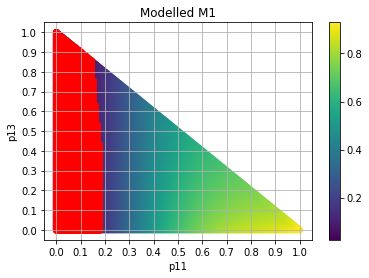

In [143]:
show_heatmap('Modelled M1', pred_m_df, "m1")

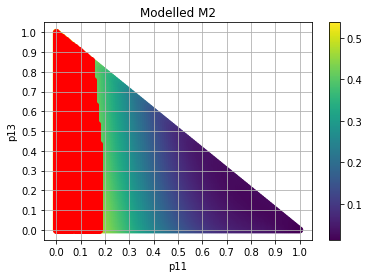

In [144]:
show_heatmap('Modelled M2', pred_m_df, "m2")

Here you can see the heatmaps of $M_1$ and $M_2$ retrieved by the simulation process. Again, close points are highlights with red.

In [139]:
df_fixed_p2 = df[(df['p21'] == 0.3) & (df['p23'] == 0.4)]

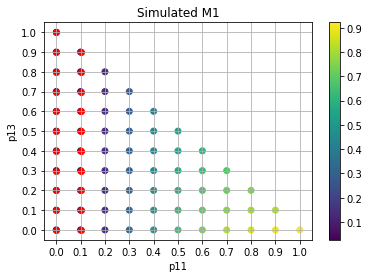

In [141]:
show_heatmap('Simulated M1', df_fixed_p2, 'm1')

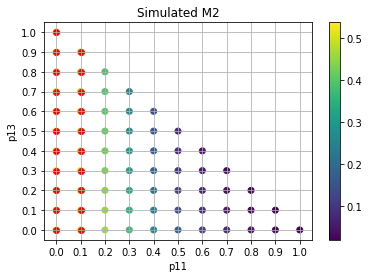

In [142]:
show_heatmap('Simulated M2', df_fixed_p2, 'm2')